In [31]:
from build_graphs import *
from tqdm import tqdm

In [73]:
feature_names = ['x', 'y', 'z', 'cell_count', 'cell_val', 'leta', 'lphi', 'lx', 'ly', 'lz', 'geta', 'gphi']

# Embedding

In [56]:
def get_one_emb_eff_purity(index, hits, truth, emb_neighbors):
    vol = hits[['volume_id', 'layer_id']].values.T
    hit = hits.iloc[index]
    pid = truth.iloc[index]['particle_id']
    
    # get true neighbors based on particle id
    if pid == 0:
        true_neighbors = []
    else:
        hit_idx = truth[truth['particle_id']==pid]['hit_id']
        true_hits = hits[hits['hit_id'].isin(hit_idx) & (hits['hit_id'] != hit['hit_id'])]
        true_neighbors = true_hits.index.values.astype(int)
    
    emb_neighbors = emb_neighbors[index]
    
    # calculate purity and eff
    n_true_neighbors = sum(map(lambda n : n in true_neighbors, emb_neighbors))
    purity = n_true_neighbors / len(emb_neighbors) if len(emb_neighbors) > 0 else None
    efficiency = n_true_neighbors / len(true_neighbors) if len(true_neighbors) > 0 else None
    return purity, efficiency

In [51]:
def get_emb_eff_purity(hits, truth, emb_neighbors):
    n_iter = len(hits)
    purity = []
    efficiency = []

    for i in tqdm(range(n_iter)):
        p, eff = get_one_emb_eff_purity(i, hits, truth, emb_neighbors)
        if p: purity.append(p)
        if eff: efficiency.append(eff)

    return purity, efficiency

# Filtering

In [52]:
def get_filter_eff_purity(hits, truth, neighbors):
    vol = hits[['volume_id', 'layer_id']].values.T

    batch_size = 64
    num_workers = 12 if DEVICE=='cuda' else 0
    dataset = EdgeData(hits[feature_names].values, vol, neighbors)
    loader = DataLoader(dataset,
                        batch_size = batch_size,
                        num_workers = num_workers,
                        collate_fn = my_collate)
    # apply filter model
    idx_pairs, scores = predict_pairs(loader, filter_model, batch_size)
    
    # get true pairs
    true_pairs = []
    truth_np = np.array(truth.values)
    
    with torch.autograd.no_grad():
        for i, pair in tqdm(enumerate(idx_pairs)):
            hit_a = truth_np[pair[0], 1]
            hit_b = truth_np[pair[1], 1]
            if hit_a != 0 and hit_a == hit_b: #compare particle id
                true_pairs.append((pair[0], pair[1]))
                
    # get filtered pairs
    filter_pairs, _ = apply_filter(idx_pairs, scores, 0.95)
    filter_pairs = [(pair[0], pair[1]) for pair in filter_pairs]
    
    # calculate efficiency and purity
    true_pairs_set = frozenset(true_pairs)
    n_true_pairs = sum(map(lambda n : n in true_pairs_set, filter_pairs))
    purity = n_true_pairs / len(filter_pairs)
    efficiency = n_true_pairs / len(true_pairs)
    return purity, efficiency

# Overall purity and efficiency

In [65]:
def get_overall_eff_purity(hits, truth, neighbors):
    vol = hits[['volume_id', 'layer_id']].values.T

    batch_size = 64
    num_workers = 12 if DEVICE=='cuda' else 0
    dataset = EdgeData(hits[feature_names].values, vol, neighbors)
    loader = DataLoader(dataset,
                        batch_size = batch_size,
                        num_workers = num_workers,
                        collate_fn = my_collate)
    # apply filter model
    idx_pairs, scores = predict_pairs(loader, filter_model, batch_size)
    
    # get true pairs from original dataset
    true_pairs = []
    for pid in tqdm(truth['particle_id'].unique()):
        if pid == 0: continue
        seed_hits = hits[truth['particle_id']==pid].index.values.astype(int)
        for i in seed_hits:
            hit = hits.iloc[i]
            true_neighbors = filter_one_neighborhood(hit['volume_id'], hit['layer_id'], seed_hits, vol[0], vol[1])
            true_pairs += [(i, n) for n in true_neighbors]
                
    # get filtered pairs
    filter_pairs, _ = apply_filter(idx_pairs, scores, 0.95)
    filter_pairs = [(pair[0], pair[1]) for pair in filter_pairs]
    
    # calculate efficiency and purity
    true_pairs_set = frozenset(true_pairs)
    n_true_pairs = sum(map(lambda n : n in true_pairs_set, filter_pairs))
    purity = n_true_pairs / len(filter_pairs)
    efficiency = n_true_pairs / len(true_pairs)
    return purity, efficiency

# Plotting

In [54]:
artifact_storage_path = "/global/cfs/cdirs/m3443/usr/aoka/data/artifacts/Training_Example_no_ptcut"
best_emb_path = os.path.join(artifact_storage_path, 'metric_learning_emb', 'best_model.pkl')
best_filter_path = os.path.join(artifact_storage_path, 'metric_learning_filter', 'best_model.pkl')    
    
emb_model = load_embed_model(best_emb_path, DEVICE).to(DEVICE)
filter_model = load_filter_model(best_filter_path, DEVICE).to(DEVICE)
emb_model.eval()
filter_model.eval()

Edge_MLP(
  (layers): ModuleList(
    (0): Linear(in_features=28, out_features=512, bias=True)
    (1): Linear(in_features=512, out_features=512, bias=True)
    (2): Linear(in_features=512, out_features=512, bias=True)
  )
  (act1): ReLU()
  (final_layer): Linear(in_features=512, out_features=1, bias=True)
  (act2): Sigmoid()
)

event: 0 number of hits: 52482


100%|██████████| 52482/52482 [09:49<00:00, 89.06it/s] 


emb result: 0.00771521702260409 0.8924984495230237
    0% of doublets filtered
   20% of doublets filtered
   40% of doublets filtered
   60% of doublets filtered
   80% of doublets filtered
  100% of doublets filtered


10485632it [00:23, 453737.09it/s]


filter result: 0.08907730748588197 0.9622583833464098
    0% of doublets filtered
   20% of doublets filtered
   40% of doublets filtered
   60% of doublets filtered
   80% of doublets filtered
  100% of doublets filtered


100%|██████████| 8187/8187 [00:32<00:00, 248.21it/s]


overall result: 0.08907730748588197 0.9339102056962025
event: 0.2 number of hits: 55094


100%|██████████| 55094/55094 [09:59<00:00, 91.89it/s] 


emb result: 0.007346040755355667 0.8924984495230237
    0% of doublets filtered
   20% of doublets filtered
   40% of doublets filtered
   60% of doublets filtered
   80% of doublets filtered
  100% of doublets filtered


11471101it [00:25, 447712.72it/s]


filter result: 0.08157498978552628 0.9622583833464098
    0% of doublets filtered
   20% of doublets filtered
   40% of doublets filtered
   60% of doublets filtered
   80% of doublets filtered
  100% of doublets filtered


100%|██████████| 8188/8188 [00:31<00:00, 256.94it/s]


overall result: 0.08157498978552628 0.9339102056962025
event: 0.4 number of hits: 57699


100%|██████████| 57699/57699 [10:23<00:00, 92.56it/s] 


emb result: 0.007015680559365761 0.8924984495230237
    0% of doublets filtered
   20% of doublets filtered
   40% of doublets filtered
   60% of doublets filtered
   80% of doublets filtered
  100% of doublets filtered


12577944it [00:28, 442660.15it/s]


filter result: 0.07464112790405418 0.9622387740338079
    0% of doublets filtered
   20% of doublets filtered
   40% of doublets filtered
   60% of doublets filtered
   80% of doublets filtered
  100% of doublets filtered


100%|██████████| 8188/8188 [00:32<00:00, 253.94it/s]


overall result: 0.07464112790405418 0.9339102056962025
event: 0.6 number of hits: 60314


100%|██████████| 60314/60314 [10:42<00:00, 93.81it/s] 


emb result: 0.006717121028668571 0.8924984495230237
    0% of doublets filtered
   20% of doublets filtered
   40% of doublets filtered
   60% of doublets filtered
   80% of doublets filtered
  100% of doublets filtered


13750204it [00:31, 441024.71it/s]


filter result: 0.06807737306994444 0.962228969677209
    0% of doublets filtered
   20% of doublets filtered
   40% of doublets filtered
   60% of doublets filtered
   80% of doublets filtered
  100% of doublets filtered


100%|██████████| 8188/8188 [00:32<00:00, 249.17it/s]


overall result: 0.06807737306994444 0.9339102056962025
event: 0.8 number of hits: 62859


100%|██████████| 62859/62859 [11:09<00:00, 93.93it/s] 


emb result: 0.00645126258630914 0.8924984495230237
    0% of doublets filtered
   20% of doublets filtered
   40% of doublets filtered
   60% of doublets filtered
   80% of doublets filtered
  100% of doublets filtered


14988048it [00:33, 452840.56it/s]


filter result: 0.062494705913494625 0.9622387740338079
    0% of doublets filtered
   20% of doublets filtered
   40% of doublets filtered
   60% of doublets filtered
   80% of doublets filtered
  100% of doublets filtered


100%|██████████| 8188/8188 [00:33<00:00, 246.85it/s]


overall result: 0.062494705913494625 0.9339102056962025
event: 1 number of hits: 65518


100%|██████████| 65518/65518 [11:22<00:00, 96.03it/s] 


emb result: 0.006198750267944672 0.8924984495230237
    0% of doublets filtered
   20% of doublets filtered
   60% of doublets filtered
   80% of doublets filtered


16364219it [00:37, 438289.69it/s]


filter result: 0.05696594240490294 0.962228969677209
    0% of doublets filtered
   20% of doublets filtered
   40% of doublets filtered
   60% of doublets filtered
   80% of doublets filtered
  100% of doublets filtered


100%|██████████| 8188/8188 [00:32<00:00, 248.25it/s]


overall result: 0.05696594240490294 0.9339102056962025


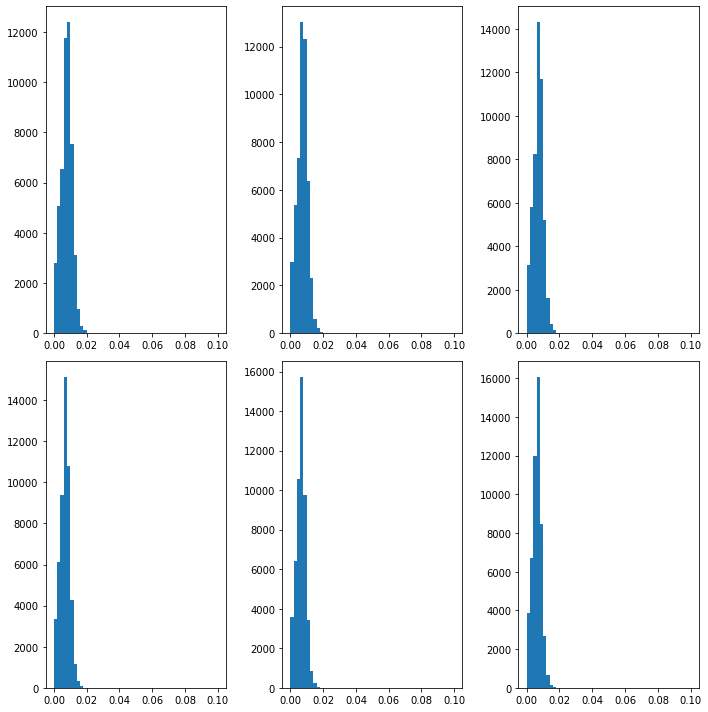

In [66]:
import matplotlib.pyplot as plt
%matplotlib inline

noise_keeps = ["0", "0.2", "0.4", "0.6", "0.8", "1"]
emb_ps = []
emb_efs = []
filter_ps = []
filter_efs = []
overall_ps = []
overall_efs = []

fig, axes = plt.subplots(2, 3, figsize=(10,10))

for i, noise_keep in enumerate(noise_keeps):
    event_name = "event000001000.pickle"
    data_path = f"/global/cfs/cdirs/m3443/usr/aoka/data/classify/Classify_Example_{noise_keep}/preprocess_raw"
    hits, truth = load_event(data_path, event_name)
    print("event:", noise_keep, "number of hits:", len(hits))
    
    neighbors = get_emb_neighbors(hits[feature_names].values, emb_model, 0.4)
    
    emb_purity, emb_efficiency = get_emb_eff_purity(hits, truth, neighbors)
    axes[i//3][i%3].hist(emb_purity, 50, range=(0, 0.1))
    emb_purity = sum(emb_purity)/len(emb_purity)
    emb_efficiency = sum(emb_efficiency)/len(emb_efficiency)
    print("emb result:", emb_purity, emb_efficiency)
    emb_ps.append(emb_purity)
    emb_efs.append(emb_efficiency)
    
    filter_purity, filter_efficiency = get_filter_eff_purity(hits, truth, neighbors)
    print("filter result:", filter_purity, filter_efficiency)
    filter_ps.append(filter_purity)
    filter_efs.append(filter_efficiency)
    
    overall_purity, overall_efficiency = get_overall_eff_purity(hits, truth, neighbors)
    print("overall result:", overall_purity, overall_efficiency)
    overall_ps.append(overall_purity)
    overall_efs.append(overall_efficiency)
    
plt.tight_layout()

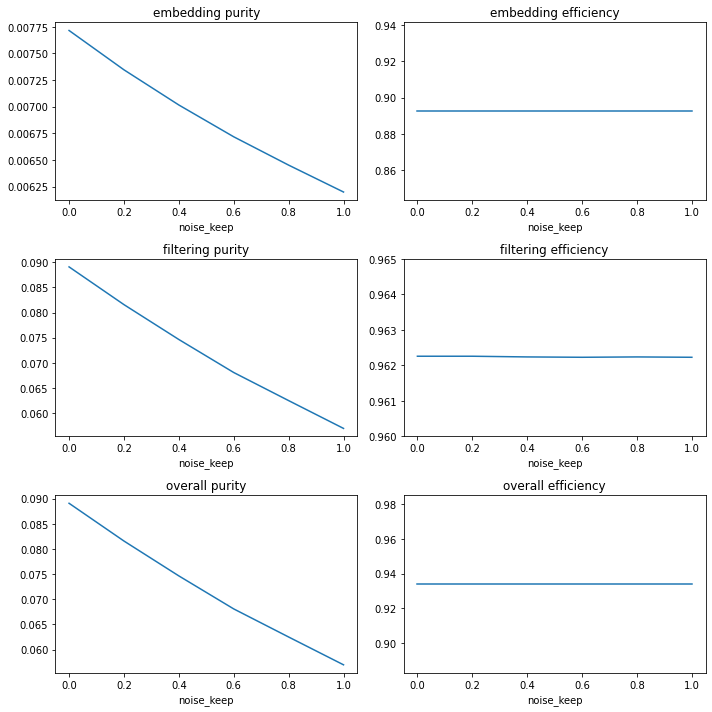

In [72]:
import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np

fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6)) = plt.subplots(3,2, figsize=(10,10))
x = [float(keep) for keep in noise_keeps]
ax1.plot(x, emb_ps)
ax1.set_title("embedding purity")
ax1.set_xlabel("noise_keep")
ax2.plot(x, emb_efs)
ax2.set_title("embedding efficiency")
ax2.set_xlabel("noise_keep")

ax3.plot(x, filter_ps)
ax3.set_title("filtering purity")
ax3.set_xlabel("noise_keep")
ax4.plot(x, filter_efs)
ax4.set_ylim(0.96, 0.965)
ax4.set_title("filtering efficiency")
ax4.set_xlabel("noise_keep")

ax5.plot(x, overall_ps)
ax5.set_title("overall purity")
ax5.set_xlabel("noise_keep")
ax6.plot(x, overall_efs)
ax6.set_title("overall efficiency")
ax6.set_xlabel("noise_keep")

plt.tight_layout()

# Noise hits in embedding neighbors

event: 0 number of hits: 52482


100%|██████████| 52482/52482 [00:48<00:00, 1087.29it/s]


result: 0.0 0.0
event: 0.2 number of hits: 55094


100%|██████████| 55094/55094 [00:54<00:00, 1017.71it/s]


result: 50.67246887138345 0.04709848525790007
event: 0.4 number of hits: 57699


100%|██████████| 57699/57699 [01:01<00:00, 940.89it/s] 


result: 102.57153503526924 0.09015420961630241
event: 0.6 number of hits: 60314


100%|██████████| 60314/60314 [01:19<00:00, 761.36it/s] 


result: 154.97746791789635 0.12942441696286214
event: 0.8 number of hits: 62859


100%|██████████| 62859/62859 [01:25<00:00, 734.58it/s] 


result: 206.26484672043782 0.1646409451015502
event: 1 number of hits: 65518


100%|██████████| 65518/65518 [01:18<00:00, 836.62it/s] 


result: 261.0072041271101 0.1985294043669833


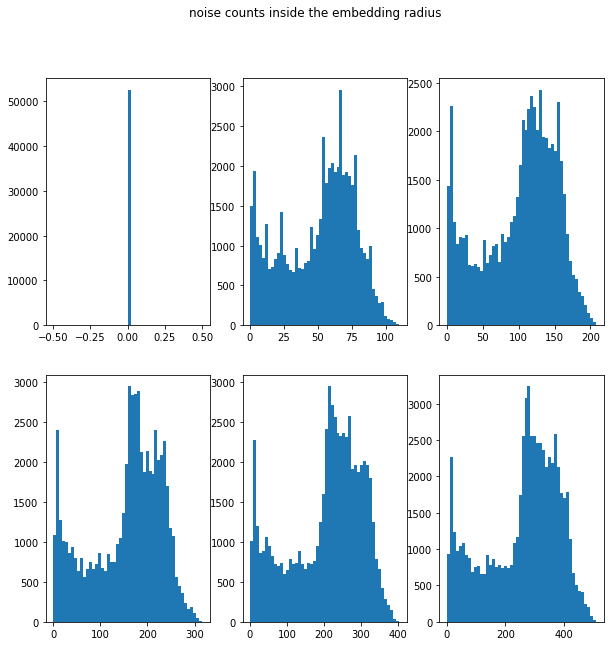

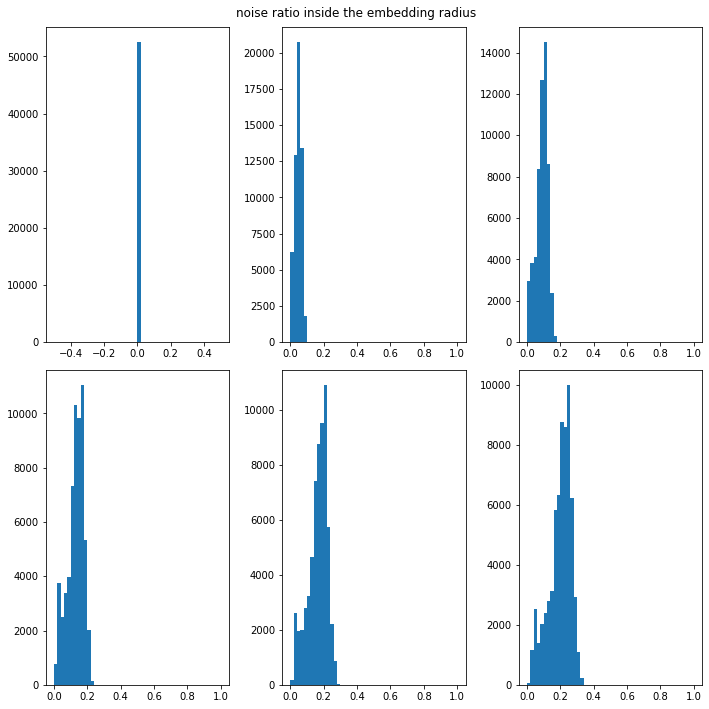

In [99]:
import matplotlib.pyplot as plt
%matplotlib inline

noise_keeps = ["0", "0.2", "0.4", "0.6", "0.8", "1"]
counts = []
ratios = []

fig1, axes1 = plt.subplots(2, 3, figsize=(10,10))
fig2, axes2 = plt.subplots(2, 3, figsize=(10,10))

fig1.suptitle("noise counts inside the embedding radius")
fig2.suptitle("noise ratio inside the embedding radius")

for i, noise_keep in enumerate(noise_keeps):
    event_name = "event000001000.pickle"
    data_path = f"/global/cfs/cdirs/m3443/usr/aoka/data/classify/Classify_Example_{noise_keep}/preprocess_raw"
    hits, truth = load_event(data_path, event_name)
    print("event:", noise_keep, "number of hits:", len(hits))
    
    neighbors = get_emb_neighbors(hits[feature_names].values, emb_model, 0.4)
    
    truth_np = np.array(truth.values)
    noise_counts = []
    noise_ratio = []
    for j in tqdm(range(len(neighbors))):
        n_noise = 0
        for k in neighbors[j]:
            if truth_np[k, 1] == 0: n_noise+=1
        noise_counts.append(n_noise)
        noise_ratio.append(n_noise / len(neighbors[j]))
    count = sum(noise_counts)/len(noise_counts)
    ratio = sum(noise_ratio)/len(noise_ratio)
    print("result:", count, ratio)
    counts.append(count)
    ratios.append(ratio)
    
    axes1[i//3][i%3].hist(noise_counts, 50)
    axes2[i//3][i%3].hist(noise_ratio, 50)
    
plt.tight_layout()
plt.show()

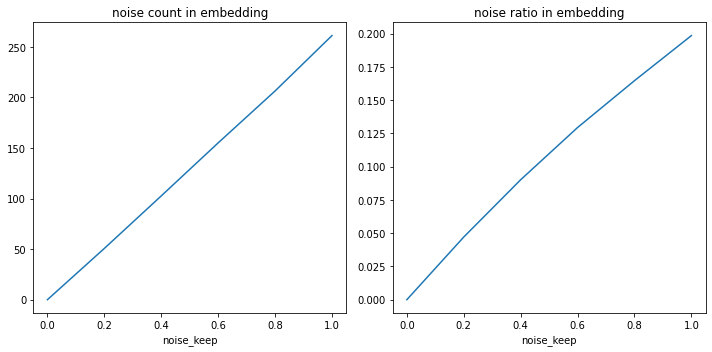

In [103]:
import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,5))
x = [float(keep) for keep in noise_keeps]
ax1.plot(x, counts)
ax1.set_title("noise count in embedding")
ax1.set_xlabel("noise_keep")
ax2.plot(x, ratios)
ax2.set_title("noise ratio in embedding")
ax2.set_xlabel("noise_keep")

plt.tight_layout()